<center><img src=title.jpg width=500px height=30%>

# <center> ИССЛЕДОВАНИЕ ДАННЫХ СТРАХОВОЙ КОМПАНИИ

## Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

В процессе своего анализа мы должны: 

1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.

2. А также ответить на ключевые вопросы HR-агентства:

    * Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
    * Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
    * Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
    * Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

На каждый вопрос необходимо ответить с уровнем значимости $\alpha=0.05$.

Ответить на эти вопросы нам помогут данные HR - Агенства.

Данные содержат следующие столбцы:
* *work_year* — Год, в котором была выплачена зарплата;
* *experience_level* — 	Опыт работы на этой должности в течение года со следующими возможными значениями:
    * EN — Entry-level/Junior;
    * MI — Mid-level/Intermediate;
    * SE — Senior-level/Expert;
    * EX — Executive-level/Director.
* *employment_type* — Тип трудоустройства для этой роли:
    * PT — неполный рабочий день;
    * FT — полный рабочий день;
    * CT — контракт;
    * FL — фриланс. 
* *job_title* — Роль, в которой соискатель работал в течение года.
* *salary* — Общая выплаченная валовая сумма заработной платы.
* *salary_currency* — Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.
* *salary_in_usd* — Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).
* *employee_residence* — Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.
* *remote_ratio* — Общий объём работы, выполняемой удалённо. Возможные значения:
    * 0 — удалённой работы нет (менее 20 %);
    * 50 — частично удалённая работа;
    * 100 — полностью удалённая работа (более 80 %).
* *company_location* — Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
* *company_size* — 	Среднее количество людей, работавших в компании в течение года:
    * S — менее 50 сотрудников (небольшая компания);
    * M — от 50 до 250 сотрудников (средняя компания);
    * L — более 250 сотрудников (крупная компания).

Источник датасета: [“Data Science Job Salaries” (kaggle.com)](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries)

## 1. Загрузка и обработка данных 

In [2]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms
from statsmodels.stats.descriptivestats import sign_test

import matplotlib.pyplot as plt
import seaborn as sns

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

In [3]:
# скачиваем датасет 
!wget "https://lms.skillfactory.ru/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block@ds_salaries.zip" 

In [4]:
# загружаем датасет
data = pd.read_csv('asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block@ds_salaries.zip' )
data.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [5]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


* Проверка на наличие пропусков и дубликатов, а также на корректность типов данных столбцов.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


В датасете 607 записей (без пропущенных значений). Все столбцы имеют корректные типы данных. 

In [7]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

# Удаляем дубликаты:
data = data.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(data.shape))

Количество дубликатов: 0
Размер таблицы после удаления дубликатов: (607, 12)


* Определение в данных неинформативныx признаков, которые не будут участвовать в исследовании.

In [8]:
# Удалим столбцы, которые не будут участвовать в исследовании.
# 
df=data.drop(['Unnamed: 0','salary','salary_currency','remote_ratio','employee_residence'],axis=1)

* Классификация всех признаков на числовые и категориальные

In [9]:
unique_list = []
# пробегаемся по именам столбцов в таблице
for col in df.columns:
    # создаём кортеж (имя столбца, число уникальных значений)
    item = (col, df[col].nunique(),df[col].dtypes)     # добавляем кортеж в список
    unique_list.append(item) 
# создаём вспомогательную таблицу и сортируем её
unique_counts = pd.DataFrame(
    unique_list,
    columns=['Column_Name', 'Num_Unique', 'Type']
).sort_values(by='Num_Unique',  ignore_index=True)
# выводим её на экран
display(unique_counts)

,Column_Name,Num_Unique,Type
0,work_year,3,int64
1,company_size,3,object
2,experience_level,4,object
3,employment_type,4,object
4,job_title,50,object
5,company_location,50,object
6,salary_in_usd,369,int64


* Классификация признаков на числовые и категориальные.

0. work_year	- Категориальный порядковый признак. int64. Количество уникальных значений-3.
   
1. company_size - Категориальный порядковый признак. object. Количество уникальных значений-3.

2. experience_level - Категориальный порядковый признак. object. Количество уникальных значений-4.

3. employment_type - Категориальный порядковый признак. object. Количество уникальных значений-4.
    
4. job_title - Категориальный номинальный признак.object. Количество уникальных значений-50

5. company_location -  Категориальный номинальный признак.object. Количество уникальных значений-50

6. salary_in_usd - Числовой непрерывный признак. int64. Количество уникальных значений-369

* Основные статистические характеристики для каждого из признаков.

In [10]:
df.describe(include=['int64','object'])

,work_year,experience_level,employment_type,job_title,salary_in_usd,company_location,company_size
count,607.000000,607,607,607,607.000000,607,607
unique,NaN,4,4,50,NaN,50,3
top,NaN,SE,FT,Data Scientist,NaN,US,M
freq,NaN,280,588,143,NaN,355,326
mean,2021.405272,NaN,NaN,NaN,112297.869852,NaN,NaN
std,0.692133,NaN,NaN,NaN,70957.259411,NaN,NaN
min,2020.000000,NaN,NaN,NaN,2859.000000,NaN,NaN
25%,2021.000000,NaN,NaN,NaN,62726.000000,NaN,NaN
50%,2022.000000,NaN,NaN,NaN,101570.000000,NaN,NaN
75%,2022.000000,NaN,NaN,NaN,150000.000000,NaN,NaN


По статистическим данным видно:
* Самая популярная профессия - Data Scientist частота повтора данной профессии среди всего списка 143 из 607
* Период анализа 2020-2022
* Самый популярный опыт работы SE — Senior-level/Expert. Частота данного значения 280 из 607
* Самый популярный тип трудоустройства  FT — полный рабочий день
* Зарплата вальируется от 2859$ до 600000$ в год. 
* Главный офис компании работодателя USA
* Самый популярный тип компании- 'M'(50-250 сотрудников штат компании)

## 2. Разведывательный анализ данных

### 2.1 Визуальный анализ данных  

* Базовый анализ для каждого признака, участвующего в исследовании:

count       607.00
mean     112297.87
std       70957.26
min        2859.00
25%       62726.00
50%      101570.00
75%      150000.00
max      600000.00
Name: salary_in_usd, dtype: float64

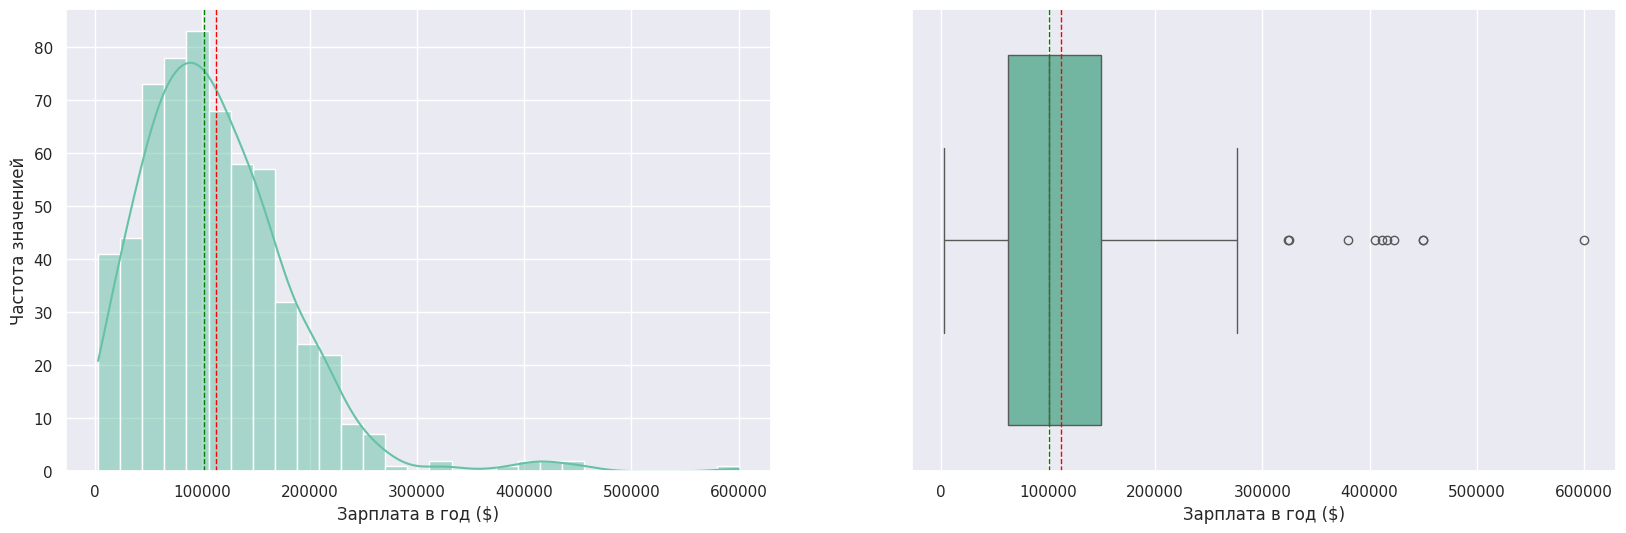

In [11]:
# Строим графики для числового признака 'salary_in_usd'
fig,axes=plt.subplots(1,2,figsize=(20,6))
# Гистограмма
sns.histplot(data=df['salary_in_usd'],kde=True, ax=axes[0])
axes[0].set(xlabel='Зарплата в год ($)', ylabel='Частота значенией');
axes[0].axvline(df['salary_in_usd'].mean(),color='red',linestyle='--',linewidth=1);
axes[0].axvline(df['salary_in_usd'].median(),color='green',linestyle='--',linewidth=1);
# Коробчатая диаграмма
sns.boxplot(x=df['salary_in_usd'], ax=axes[1])
axes[1].set(xlabel='Зарплата в год ($)');
axes[1].axvline(df['salary_in_usd'].mean(),color='red',linestyle='--',linewidth=1);
axes[1].axvline(df['salary_in_usd'].median(),color='green',linestyle='--',linewidth=1);

display(df['salary_in_usd'].describe().round(2))

На графике видно, что медиана( около 100 тыс.) и среднее( около 110 тыс.) не находятся в одной линии. Имеются выбросы. Не нормальное распределение признака. Зарплата сосредоточена в основном от 0 до 170 тыс.$. За все периоды 2020-2022

Чтобы построить графики категориальных признаков, необходимо их преобразовать. четыре из семи признаков имеют по 3-4 уникальных значения. Их мы оставляем как есть. А остальные признаки преобразуем для уменьшения количества уникальных значений в каждом признаке до уровня 3-10 значений.

In [12]:
# Напишем lambda функции для наших значений и применим их к нашим признакам.
# Рассмотрим распределение значений.  
df['job_title'].value_counts().head(10)
# Возьмем для работы 4 значения, остальные преобразуем в other
df['job_title'] = df['job_title'].apply(lambda x: x if x in ('Data Scientist','Data Engineer','Data Analyst','Machine Learning Engineer') else 'Other')
# Сделаем так же с другим признаком.
df['company_location'] = df['company_location'].apply(lambda x: x if x in ('US','GB','CA','DE','IN') else 'Other')
# Преобразуем числовой признак в категориальный, что бы получилась корректная гистограмма. Не было промежудочный кварталов на гистограмме.
df['work_year']=df['work_year'].astype('str')

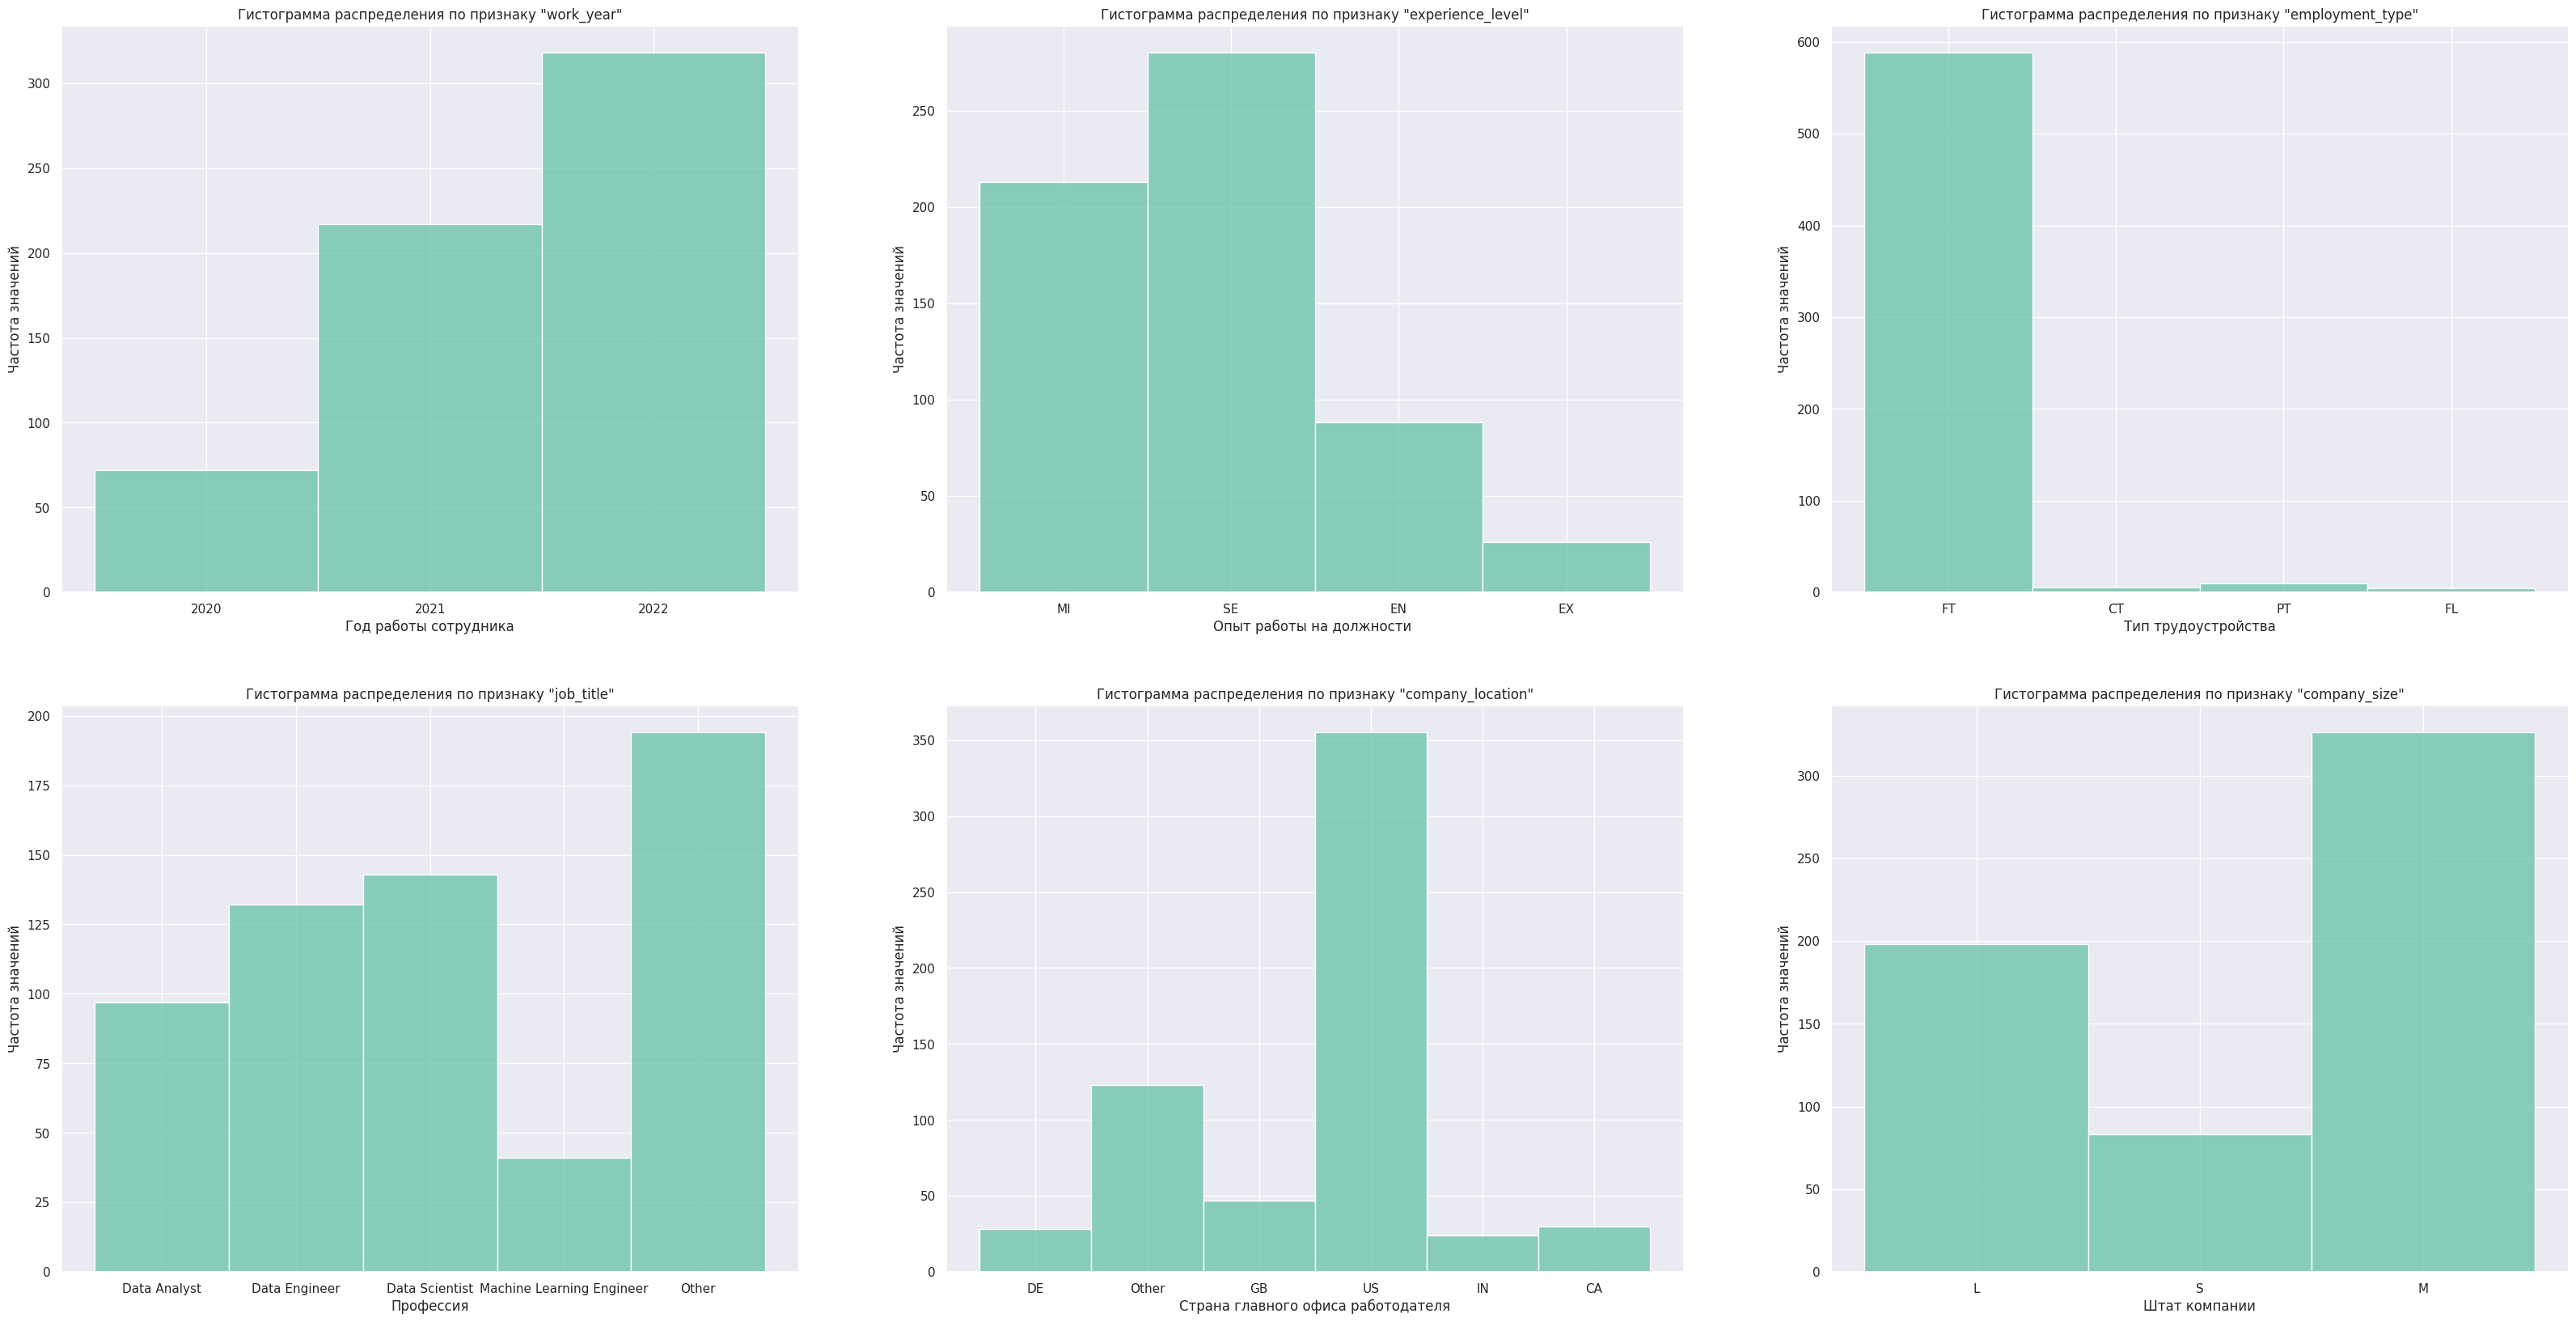

In [13]:
# Строим графики для категориальных признаков: 'work_year','job_title','company_size'
# график распределения 'work_year'
fig, axes = plt.subplots(2, 3, figsize=(40,20))
sns.histplot( df['work_year'], ax=axes[0,0],bins=3);
axes[0,0].set(xlabel='Год работы сотрудника', ylabel='Частота значений');
axes[0,0].set_title('Гистограмма распределения по признаку "work_year"');

# график распределения 'experience_level'
sns.histplot(df['experience_level'],ax=axes[0,1]);
axes[0,1].set(xlabel='Опыт работы на должности ', ylabel='Частота значений');
axes[0,1].set_title('Гистограмма распределения по признаку "experience_level"');

# график распределения 'employment_type'
sns.histplot(df['employment_type'],ax=axes[0,2]);
axes[0,2].set(xlabel='Тип трудоустройства', ylabel='Частота значений');
axes[0,2].set_title('Гистограмма распределения по признаку "employment_type"');

# график распределения 'job_title'
sns.histplot(df['job_title'].sort_values(),ax=axes[1,0]);
axes[1,0].set(xlabel='Профессия', ylabel='Частота значений');
axes[1,0].set_title('Гистограмма распределения по признаку "job_title"');

# график распределения 'company_location'
sns.histplot(df['company_location'],ax=axes[1,1]);
axes[1,1].set(xlabel='Страна главного офиса работодателя', ylabel='Частота значений');
axes[1,1].set_title('Гистограмма распределения по признаку "company_location"');

# график распределения 'company_size'
sns.histplot(df['company_size'],ax=axes[1,2]);
axes[1,2].set(xlabel='Штат компании', ylabel='Частота значений');
axes[1,2].set_title('Гистограмма распределения по признаку "company_size"');



1. По графикам видно, самый частый год- 2022
2. Опыт работы на долженности SE — Senior-level/Expert;
3. Тип трудоустройства самый частый и основной FT — полный рабочий день
4. Топ 4 профессий:Data Scientist,Data Engineer,Data Analyst,Machine Learning Engineer
5. Страна-работодатель это US
6. Самый распространненый тип компании это 'M'(50-250 сотрудников)

* Демонстрация влияния каждого из признаков, участвующих в исследовании, на зарплату по всем наименованиям Data Scientist или на зарплату по всем должностям.

* А) Распределение зарплат по годам по всем наименованиям профессий 

count      mean      std      min  \
job_title                 work_year                                      
Data Analyst              2020         7.0   45547.0  37761.0   6072.0   
                          2021        17.0   79505.0  40207.0  10354.0   
                          2022        73.0  100551.0  36488.0  20000.0   
Data Engineer             2020        11.0   88162.0  46473.0  33511.0   
                          2021        32.0   83203.0  52927.0   4000.0   
                          2022        89.0  126376.0  55954.0  25000.0   
Data Scientist            2020        21.0   85971.0  81437.0  21669.0   
                          2021        45.0   70672.0  45423.0   2859.0   
                          2022        77.0  136172.0  54563.0  18442.0   
Machine Learning Engineer 2020         5.0  125390.0  85717.0  43331.0   
                          2021        18.0   74611.0  52393.0  20000.0   
                          2022        18.0  129452.0  56541.0  37300.0   
Other                     2020        28.0  113485.0  98408.0   5707.0   
                          2021       105.0  125057.0  98432.0   5409.0   
                          2022        61.0  134344.0  77689.0  10000.0   

                                          25%       50%       75%       max  
job_title                 work_year                                          
Data Analyst              2020         9000.0   46759.0   78500.0   91000.0  
                          2021        60000.0   75000.0   90000.0  200000.0  
                          2022        75000.0  105000.0  126500.0  170000.0  
Data Engineer             2020        51320.0   74130.0  111436.0  188000.0  
                          2021        29940.0   78416.0  111831.0  200000.0  
                          2022        78526.0  120000.0  160000.0  324000.0  
Data Scientist            2020        42197.0   62726.0  105000.0  412000.0  
                          2021        33808.0   73000.0  100000.0  165000.0  
                          2022       100000.0  140000.0  176000.0  260000.0  
Machine Learning Engineer 2020        45618.0  138000.0  150000.0  250000.0  
                          2021        30266.0   70132.0   87740.0  200000.0  
                          2022        87552.0  120000.0  183486.0  220000.0  
Other                     2020        54545.0   99000.0  127500.0  450000.0  
                          2021        60000.0  102839.0  170000.0  600000.0  
                          2022        78791.0  137141.0  175000.0  405000.0

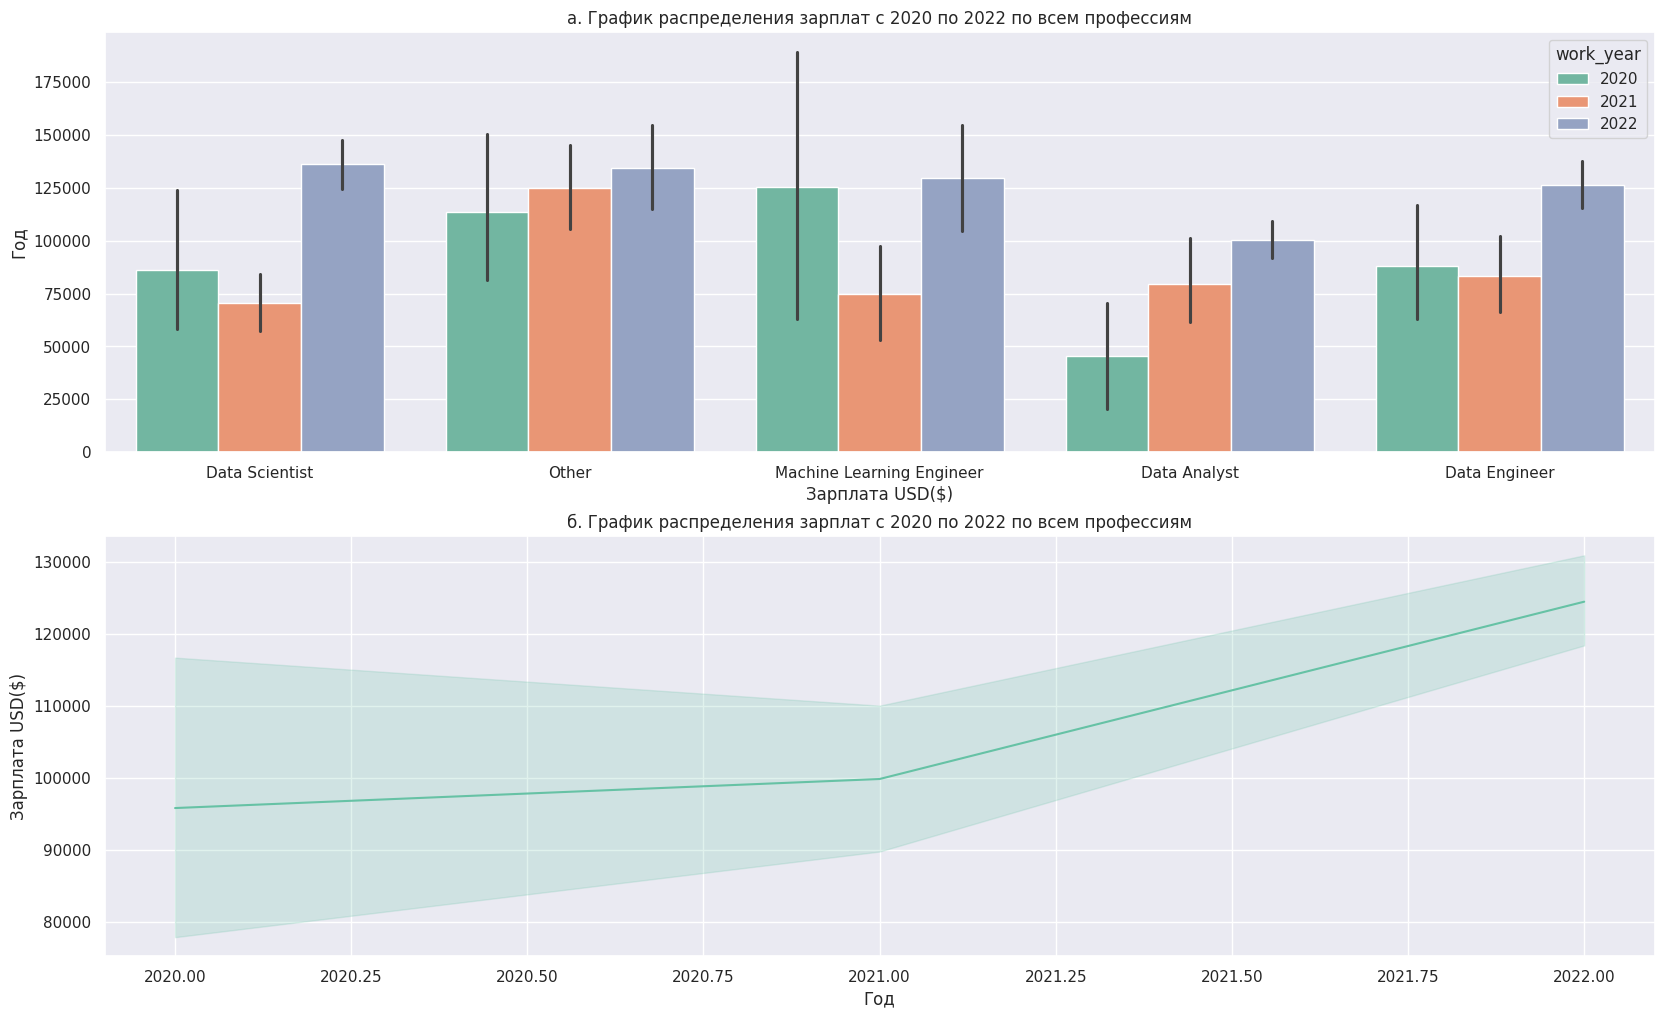

In [14]:
fig,(ax1)=plt.subplots(2,1,figsize=(20,12))
sns.barplot(df,x='job_title',y='salary_in_usd',hue='work_year',ax=ax1[0]);
ax1[0].set(xlabel='Зарплата USD($)', ylabel='Год');
ax1[0].set_title('a. График распределения зарплат с 2020 по 2022 по всем профессиям');
sns.lineplot(data=data,x='work_year',y='salary_in_usd',ax=ax1[1])
ax1[1].set(ylabel='Зарплата USD($)', xlabel='Год');
ax1[1].set_title('б. График распределения зарплат с 2020 по 2022 по всем профессиям');
display(df.groupby(['job_title','work_year'])['salary_in_usd'].describe().round())

На графике отчетливо видно, что зарплаты по всем должностям за один и тот же период времени(2020-2022 гг.) до 2021 года росла постепенно. После этой отметки она за год резко устремилась со 100 тыс. к 125 тыс.$ в год. Так же резкий рост виден на графике а) у Data Scientist 

* B) Распределение зарплаты в зависимости от опыта работы.

count      mean       std  \
job_title                 experience_level                              
Data Analyst              EN                 12.0   53961.0   30233.0   
                          EX                  2.0  120000.0   14142.0   
                          MI                 29.0   71699.0   37711.0   
                          SE                 54.0  111923.0   31017.0   
Data Engineer             EN                 12.0   58934.0   25523.0   
                          EX                  4.0  245500.0   55121.0   
                          MI                 53.0   85986.0   44478.0   
                          SE                 63.0  137036.0   46757.0   
Data Scientist            EN                 22.0   55331.0   31238.0   
                          MI                 60.0   82039.0   46870.0   
                          SE                 61.0  152971.0   58985.0   
Machine Learning Engineer EN                  9.0   86996.0   75601.0   
                          MI                 12.0   74467.0   31865.0   
                          SE                 20.0  131176.0   62896.0   
Other                     EN                 33.0   62716.0   50169.0   
                          EX                 20.0  198110.0  128182.0   
                          MI                 59.0  106622.0   97334.0   
                          SE                 82.0  148549.0   70076.0   

                                                 min       25%       50%  \
job_title                 experience_level                                 
Data Analyst              EN                  6072.0   40088.0   59551.0   
                          EX                110000.0  115000.0  120000.0   
                          MI                  8000.0   45807.0   62000.0   
                          SE                 60000.0   90320.0  111912.0   
Data Engineer             EN                 21637.0   44778.0   56388.0   
                          EX                200000.0  212000.0  229000.0   
                          MI                  4000.0   63900.0   78526.0   
                          SE                 25000.0  106900.0  136994.0   
Data Scientist            EN                  4000.0   31474.0   50484.0   
                          MI                  2859.0   41768.0   77479.0   
                          SE                 20171.0  120000.0  140400.0   
Machine Learning Engineer EN                 20000.0   24823.0   81000.0   
                          MI                 24823.0   47111.0   80712.0   
                          SE                 24342.0   70149.0  135000.0   
Other                     EN                  5707.0   18053.0   59102.0   
                          EX                 69741.0  127066.0  160771.0   
                          MI                  5409.0   54598.0   75000.0   
                          SE                 18907.0  102919.0  148030.0   

                                                 75%       max  
job_title                 experience_level                      
Data Analyst              EN                 74000.0   91000.0  
                          EX                125000.0  130000.0  
                          MI                 90000.0  167000.0  
                          SE                129750.0  200000.0  
Data Engineer             EN                 66885.0  120000.0  
                          EX                262500.0  324000.0  
                          MI                106000.0  206699.0  
                          SE                162540.0  243900.0  
Data Scientist            EN                 85027.0  105000.0  
                          MI                118265.0  200000.0  
                          SE                180000.0  412000.0  
Machine Learning Engineer EN                125000.0  250000.0  
                          MI                 91030.0  124333.0  
                          SE                189650.0  220000.0  
Other                 

 * EN — Entry-level/Junior; * MI — Mid-level/Intermediate; * SE — Senior-level/Expert; * EX — Executive-level/Director.


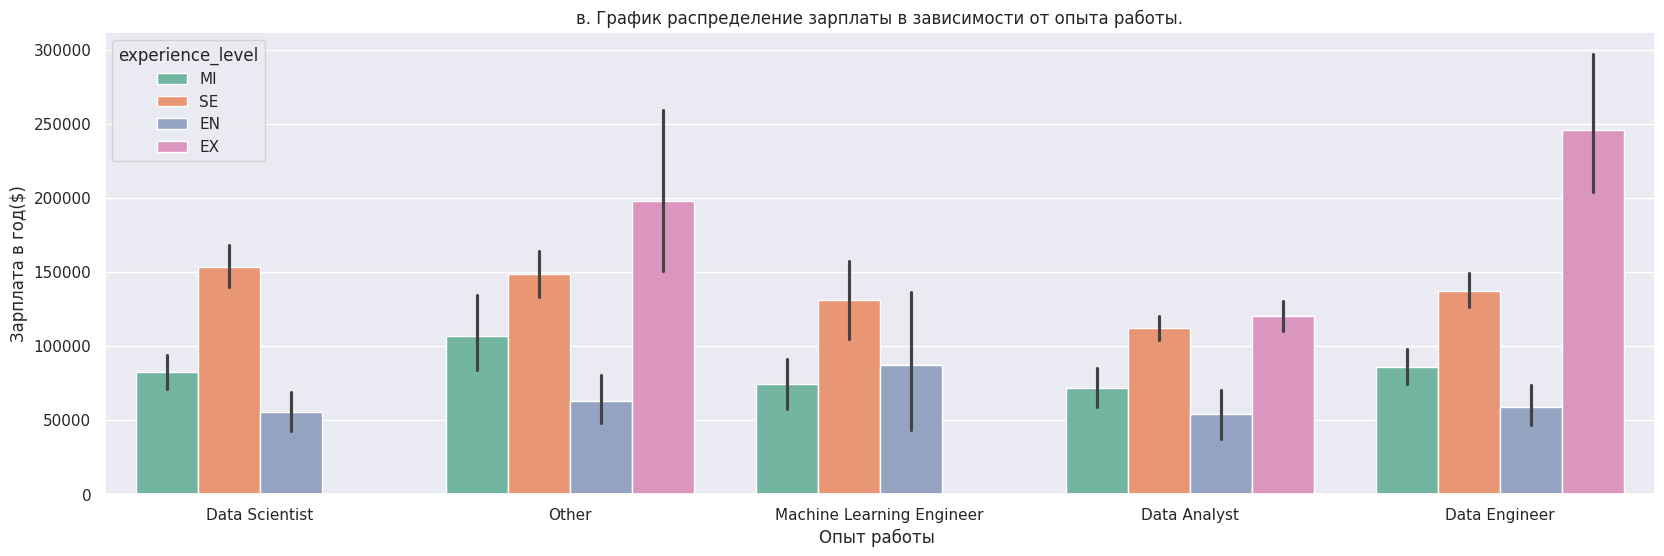

In [15]:
fig,(ax2)=plt.subplots(1,1,figsize=(20,6))
sns.barplot(df,x='job_title',y='salary_in_usd',hue='experience_level',ax=ax2);
ax2.set(xlabel='Опыт работы ', ylabel='Зарплата в год($)');
ax2.set_title('в. График распределение зарплаты в зависимости от опыта работы.');
display(df.groupby(['job_title','experience_level'])['salary_in_usd'].describe().round())
print(' * EN — Entry-level/Junior; * MI — Mid-level/Intermediate; * SE — Senior-level/Expert; * EX — Executive-level/Director.')


Как и следовало ожидать, зарплата специалиста прямым образом зависит от опыта работы(должности) сотрудника. Видно, поступательно, как меняется средняя зарплата от опыта работы.

Этим графиком хотелось бы показать, как в целом влияет опыт работы на зарплату специалиста. Начинающий специалист Data Scientist может расчитывать на зарплату до 200 тыс. долларов в год. Ну а средние показатели для начинающего 25% - 31 тыс. долларов до 75%-85 тыс. долларов в год. Уровни зарплат специалистов с опытом уже гораздо выше. Поэтому в данном направлении есть куда расти. Уровень SE DS- выше немного чем уровень зарплаты в целом по всем должностям.

* C) Зависимость зарплаты от типа трудоустройства.

count      mean       std  \
job_title                 employment_type                              
Data Analyst              FT                96.0   93753.0   39259.0   
                          PT                 1.0   10354.0       NaN   
Data Engineer             FL                 1.0   20000.0       NaN   
                          FT               129.0  114225.0   57350.0   
                          PT                 2.0   62349.0   10454.0   
Data Scientist            FL                 1.0  100000.0       NaN   
                          FT               140.0  108923.0   64372.0   
                          PT                 2.0   60834.0   55388.0   
Machine Learning Engineer FT                41.0  104880.0   63219.0   
Other                     CT                 5.0  184575.0  156251.0   
                          FL                 2.0   36000.0   33941.0   
                          FT               182.0  128762.0   89328.0   
                          PT                 5.0   14797.0    8601.0   

                                                min       25%       50%  \
job_title                 employment_type                                 
Data Analyst              FT                 6072.0   63373.0   90660.0   
                          PT                10354.0   10354.0   10354.0   
Data Engineer             FL                20000.0   20000.0   20000.0   
                          FT                 4000.0   72212.0  108800.0   
                          PT                54957.0   58653.0   62349.0   
Data Scientist            FL               100000.0  100000.0  100000.0   
                          FT                 2859.0   55490.0  104796.0   
                          PT                21669.0   41252.0   60834.0   
Machine Learning Engineer FT                20000.0   51064.0   87932.0   
Other                     CT                31875.0  100000.0  105000.0   
                          FL                12000.0   24000.0   36000.0   
                          FT                 5707.0   64086.0  113762.0   
                          PT                 5409.0   12000.0   12000.0   

                                                75%       max  
job_title                 employment_type                      
Data Analyst              FT               117262.0  200000.0  
                          PT                10354.0   10354.0  
Data Engineer             FL                20000.0   20000.0  
                          FT               154600.0  324000.0  
                          PT                66045.0   69741.0  
Data Scientist            FL               100000.0  100000.0  
                          FT               141975.0  412000.0  
                          PT                80417.0  100000.0  
Machine Learning Engineer FT               150000.0  250000.0  
Other                     CT               270000.0  416000.0  
                          FL                48000.0   60000.0  
                          FT               169500.0  600000.0  
                          PT                15966.0   28609.0


* FT — полный рабочий день; * PT — неполный рабочий день; * CT — контракт; * FL — фриланс.


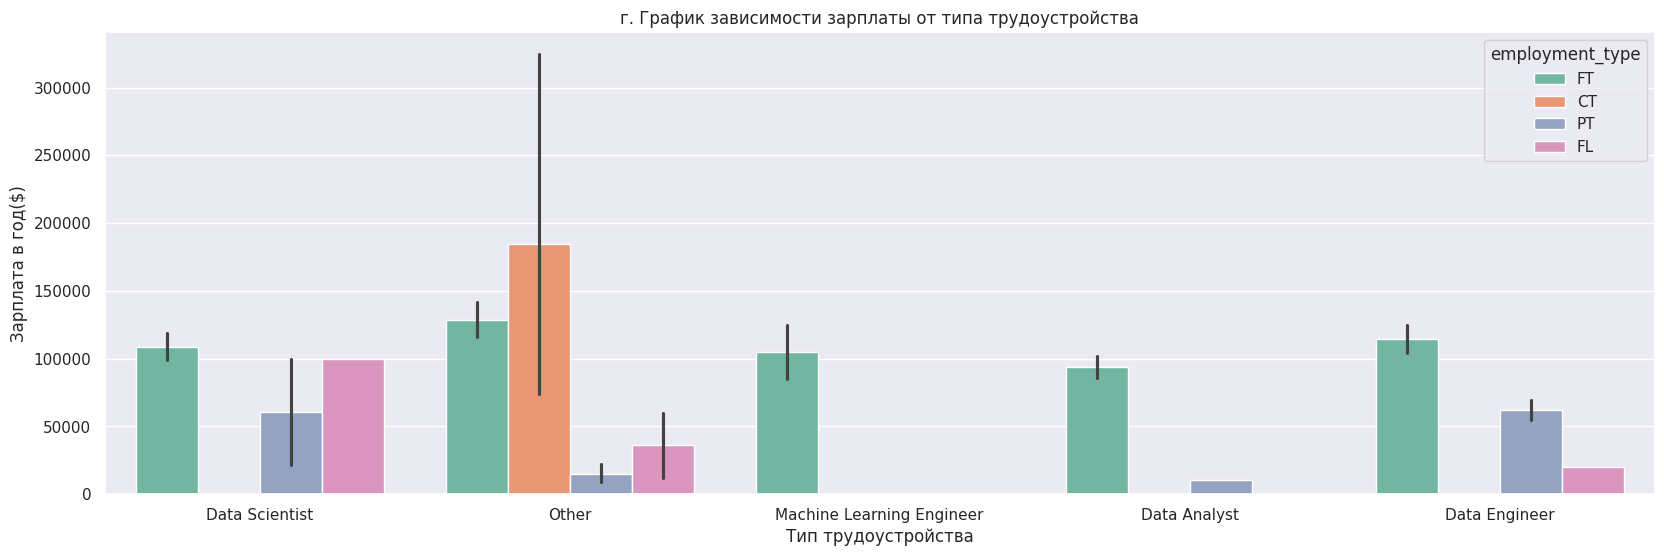

In [16]:

fig,(ax3)=plt.subplots(1,1,figsize=(20,6))
sns.barplot(df,x='job_title',y='salary_in_usd',hue='employment_type',ax=ax3);
ax3.set(xlabel='Тип трудоустройства', ylabel='Зарплата в год($)');
ax3.set_title('г. График зависимости зарплаты от типа трудоустройства');
display(df.groupby(['job_title','employment_type'])['salary_in_usd'].describe().round())
print()
print('* FT — полный рабочий день; * PT — неполный рабочий день; * CT — контракт; * FL — фриланс.')

На графике видна зависимость от типа трудоустройства существует, если полный рабочий день у сотрудника, то зп выше. В основном, но есть и контракты, которые оцениваются выше, хоть и наблюдений всего 5.График показывает, что: 

In [17]:
data[data['employment_type']=='CT']

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
28,28,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L
78,78,2021,MI,CT,ML Engineer,270000,USD,270000,US,100,US,L
225,225,2021,EX,CT,Principal Data Scientist,416000,USD,416000,US,100,US,S
283,283,2021,SE,CT,Staff Data Scientist,105000,USD,105000,US,100,US,M
489,489,2022,EN,CT,Applied Machine Learning Scientist,29000,EUR,31875,TN,100,CZ,M


Контракты есть даже у двух новичков. Остальные конечно уровнем выше.

* D) Зависимость зарплаты от наименования профессии.

,count,mean,std,min,25%,50%,75%,max
job_title,,,,,,,,
Data Analyst,97.0,92893.0,39961.0,6072.0,62000.0,90320.0,116150.0,200000.0
Data Engineer,132.0,112725.0,57629.0,4000.0,70040.0,105500.0,154600.0,324000.0
Data Scientist,143.0,108188.0,64113.0,2859.0,54724.0,103691.0,140850.0,412000.0
Machine Learning Engineer,41.0,104880.0,63219.0,20000.0,51064.0,87932.0,150000.0,250000.0
Other,194.0,126307.0,92180.0,5409.0,61042.0,110000.0,167969.0,600000.0


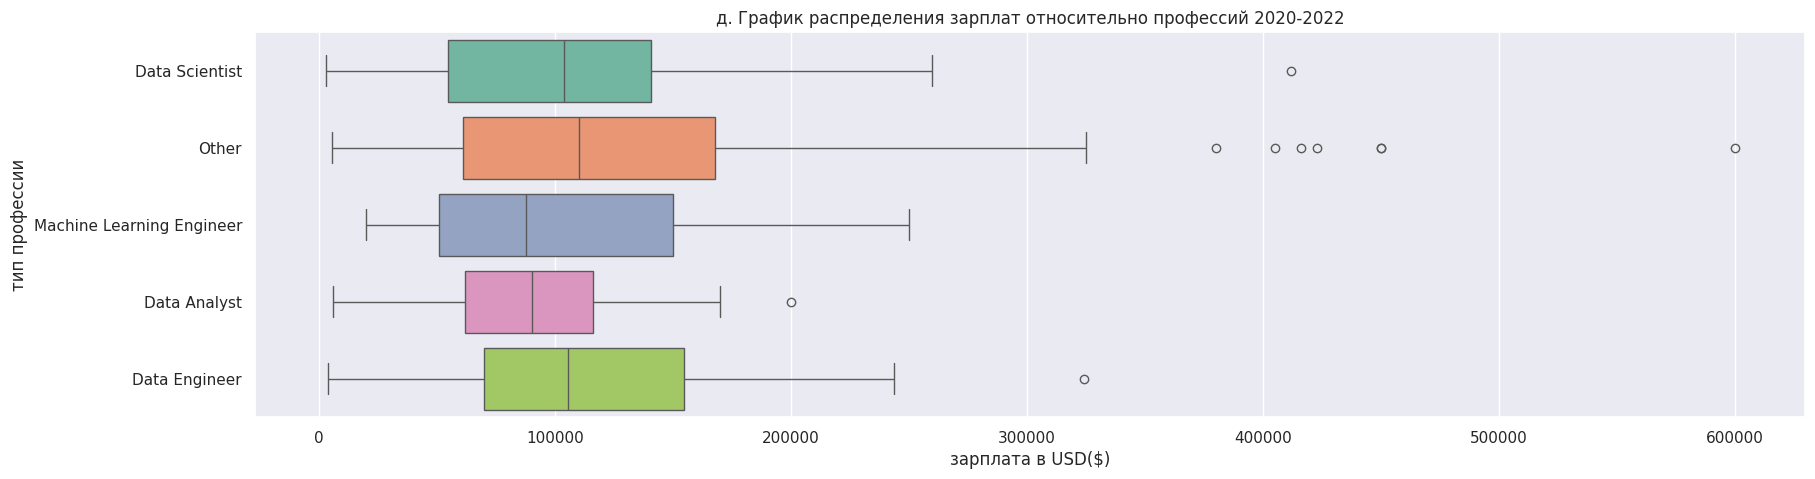

In [120]:

fig,(ax4)=plt.subplots(1,1,figsize=(20,5))

sns.boxplot(df,x='salary_in_usd',y='job_title',ax=ax4,hue='job_title');
ax4.set(xlabel='зарплата в USD($)', ylabel='тип профессии');
ax4.set_title('д. График распределения зарплат относительно профессий 2020-2022');
print()

display(df.groupby('job_title')['salary_in_usd'].describe().round())



График показывает распределение зарплат внутри каждой профессии(берем топ 4) 
  Медиана DS находится на одном из первых мест(103 тыс.$ и Data Engineer 105 тыс$). Не берем во внимание распределение Other, т.к. там очень много внутри профессий  разных и должностей. 
  Зарплата DS распределена 6072$ до 412 000$ Именно максимальное значение выше чем у всех остальных.


* E) Зависимость зарплаты от страны компании.

,count,mean,std,min,25%,50%,75%,max
company_location,,,,,,,,
CA,30.0,99824.0,46329.0,52000.0,69730.0,81896.0,117916.0,225000.0
DE,28.0,81887.0,39196.0,15966.0,58986.0,78015.0,90734.0,173762.0
GB,47.0,81583.0,29524.0,37300.0,57575.0,78526.0,103931.0,183228.0
IN,24.0,28582.0,22698.0,5409.0,16735.0,22124.0,32163.0,94665.0
Other,123.0,58677.0,41560.0,2859.0,32974.0,50180.0,75535.0,260000.0
US,355.0,144055.0,69907.0,5679.0,100000.0,135000.0,170000.0,600000.0


count      mean      std      min  \
job_title                 company_location                                      
Data Analyst              CA                  9.0   81487.0  29047.0  52000.0   
                          DE                  1.0   63831.0      NaN  63831.0   
                          GB                  5.0   50876.0   9685.0  39263.0   
                          IN                  1.0    6072.0      NaN   6072.0   
                          Other              10.0   30810.0  17947.0   8000.0   
                          US                 71.0  107674.0  31812.0  50000.0   
Data Engineer             DE                  4.0   58187.0   4793.0  54742.0   
                          GB                 20.0   80306.0  20278.0  45807.0   
                          IN                  2.0   26032.0   6216.0  21637.0   
                          Other              21.0   52961.0  24181.0   4000.0   
                          US                 85.0  139725.0  52387.0  20000.0   
Data Scientist            CA                  5.0   77787.0  19302.0  52396.0   
                          DE                  7.0   69640.0  25046.0  25532.0   
                          GB                 11.0   88177.0  41394.0  39263.0   
                          IN                  8.0   26108.0  10248.0   9466.0   
                          Other              28.0   49782.0  31390.0   2859.0   
                          US                 84.0  143116.0  56253.0   5679.0   
Machine Learning Engineer DE                  4.0   73080.0  32419.0  24823.0   
                          GB                  3.0   86597.0  44653.0  37300.0   
                          IN                  3.0   36869.0  25550.0  20000.0   
                          Other              15.0   62165.0  26157.0  21844.0   
                          US                 16.0  169056.0  44460.0  81000.0   
Other                     CA                 16.0  117024.0  54048.0  54238.0   
                          DE                 12.0  101372.0  48623.0  15966.0   
                          GB                  8.0   93021.0  25181.0  50000.0   
                          IN                 10.0   30835.0  31525.0   5409.0   
                          Other              49.0   70829.0  54365.0   5882.0   
                          US                 99.0  170622.0  99016.0  12000.0   

                                                 25%       50%       75%  \
job_title                 company_location                                 
Data Analyst              CA                 61300.0   71786.0   85000.0   
                          DE                 63831.0   63831.0   63831.0   
                          GB                 45807.0   51519.0   52351.0   
                          IN                  6072.0    6072.0    6072.0   
                          Other              12766.0   32974.0   43966.0   
                          US                 87500.0  106260.0  127688.0   
Data Engineer             DE                 54903.0   56496.0   59780.0   
                          GB                 65876.0   78526.0   96751.0   
                          IN                 23835.0   26032.0   28230.0   
                          Other              33511.0   49461.0   70139.0   
                          US                106000.0  136000.0  165400.0   
Data Scientist            CA                 69336.0   75774.0   87738.0   
                          DE                 55997.0   79833.0   89694.0   
                          GB                 60847.0   76958.0  110808.0   
                          IN                 18058.0   29075.0   32163.0   
                          Other              35699.0   41118.0   61782.0   
                          US                105000.0  140000.0  167750.0   
Machine Learning Engineer DE                 69956.0   86466.0   89590.0   
                          GB                 67729.0   98158.0  111246.0   
                 

*CA-КАНАДА, *DE-ГЕРМАНИЯ ,GB-ВЕЛИКОБРИТАНИЯ ,IN-ИНДИЯ ,US-США , OTHER-ДРУГИЕ 


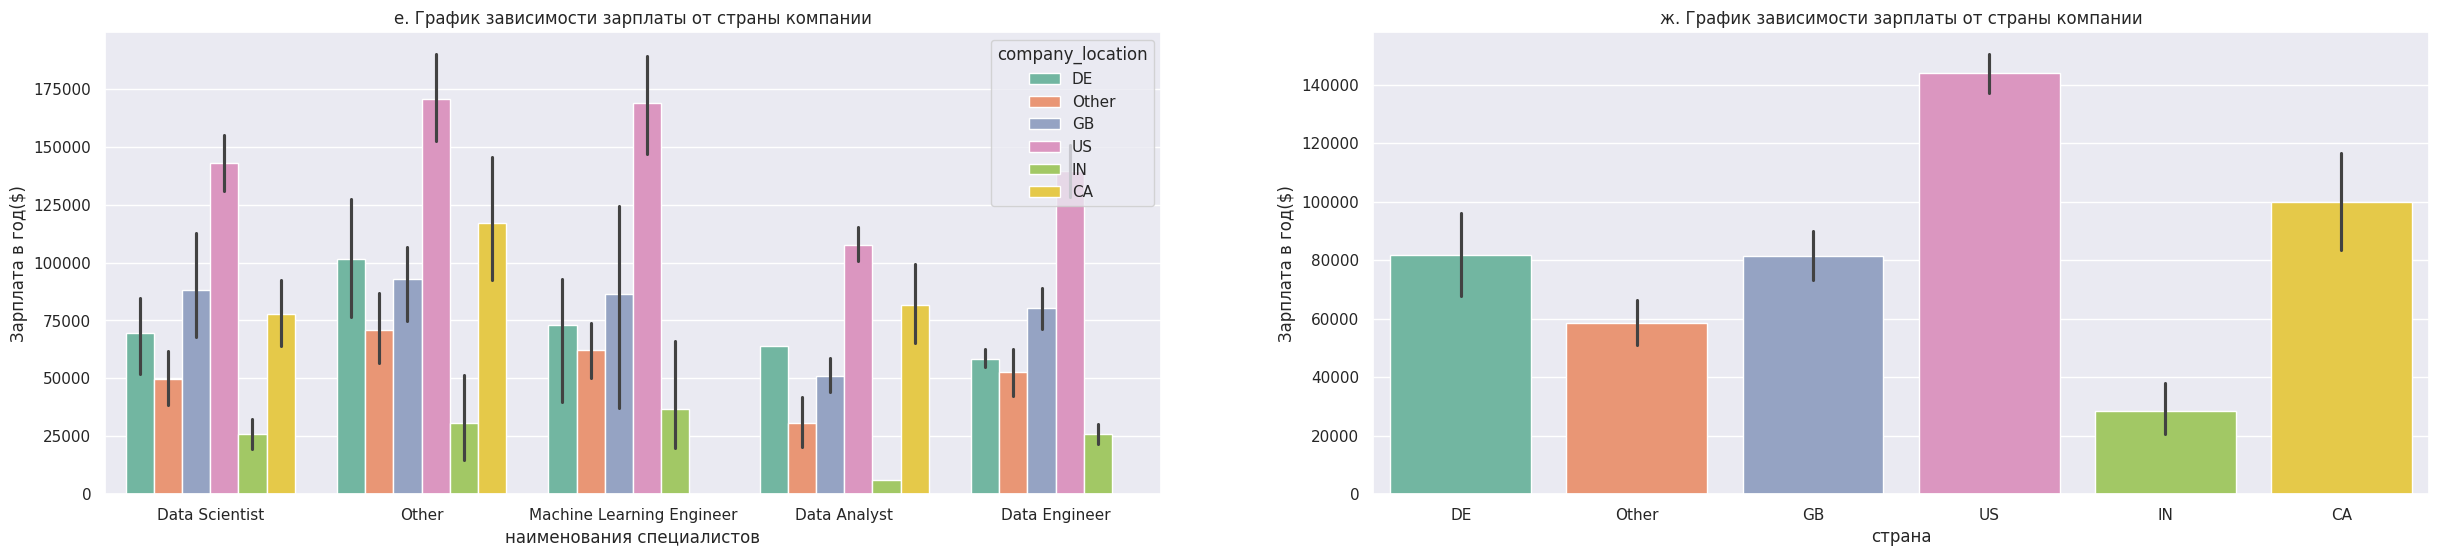

In [18]:

fig,(ax5)=plt.subplots(1,2,figsize=(30,6))
sns.barplot(df,x='job_title',y='salary_in_usd',hue='company_location',ax=ax5[0]);
ax5[0].set(xlabel='наименования специалистов', ylabel='Зарплата в год($)');
ax5[0].set_title('е. График зависимости зарплаты от страны компании');
sns.barplot(df,x='company_location',y='salary_in_usd',hue='company_location',ax=ax5[1]);
ax5[1].set(xlabel='страна', ylabel='Зарплата в год($)');
ax5[1].set_title('ж. График зависимости зарплаты от страны компании');
display(df.groupby('company_location')['salary_in_usd'].describe().round())
print()
display(df.groupby(['job_title','company_location'])['salary_in_usd'].describe().round())
print( '*CA-КАНАДА, *DE-ГЕРМАНИЯ ,GB-ВЕЛИКОБРИТАНИЯ ,IN-ИНДИЯ ,US-США , OTHER-ДРУГИЕ ')


Конечно, как и следовало ожидать, что самые высокие зарплаты для сферы IT это Америка. На графике это отчетливо видно и для IT в целом, и для всех специалистов DS.

* У Индии этот показатель самый низкий до 94 тыс.$ в год. 

* Поэтому, если рассматриваем работу за границей то выбор очевиден: США, Канада или Англия. 

* В  США медиана находится на отметке 135 тыс. $ в год для DS, это - 12 тыс.$ в месяц - зарплата для специалиста.

* F) Зависимость зарплаты от размера компании.

,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,198.0,119243.0,86157.0,5882.0,61042.0,100000.0,154600.0,600000.0
M,326.0,116905.0,59288.0,4000.0,78132.0,113188.0,152875.0,450000.0
S,83.0,77633.0,63462.0,2859.0,41943.0,65000.0,100000.0,416000.0


count      mean       std      min  \
job_title                 company_size                                       
Data Analyst              L              13.0   81778.0   46074.0   8000.0   
                          M              76.0   99545.0   36413.0  10354.0   
                          S               8.0   47759.0   31887.0   6072.0   
Data Engineer             L              37.0  104256.0   56225.0  20000.0   
                          M              89.0  119373.0   58153.0   4000.0   
                          S               6.0   66342.0   28862.0  33511.0   
Data Scientist            L              45.0  103313.0   71815.0  13400.0   
                          M              77.0  126381.0   56390.0   4000.0   
                          S              21.0   51926.0   33216.0   2859.0   
Machine Learning Engineer L              13.0   98464.0   73863.0  24342.0   
                          M              16.0  126732.0   66131.0  21844.0   
                          S              12.0   82695.0   36574.0  20000.0   
Other                     L              90.0  141782.0  102844.0   5882.0   
                          M              68.0  120037.0   77797.0   5409.0   
                          S              36.0   99461.0   83313.0   9272.0   

                                            25%       50%       75%       max  
job_title                 company_size                                         
Data Analyst              L             62000.0   75000.0   91000.0  200000.0  
                          M             74196.0  101050.0  126500.0  170000.0  
                          S             17500.0   58000.0   65000.0   90000.0  
Data Engineer             L             69741.0  100000.0  150000.0  209100.0  
                          M             78526.0  115000.0  156600.0  324000.0  
                          S             47517.0   65511.0   74130.0  115000.0  
Data Scientist            L             50000.0   90734.0  135000.0  412000.0  
                          M             90000.0  130000.0  165000.0  260000.0  
                          S             21669.0   49268.0   82500.0  105000.0  
Machine Learning Engineer L             46597.0   66265.0  150000.0  250000.0  
                          M             86635.0  122166.0  189650.0  220000.0  
                          S             60570.0   77500.0  120000.0  138000.0  
Other                     L             71934.0  118552.0  176250.0  600000.0  
                          M             59000.0  116738.0  168406.0  450000.0  
                          S             48974.0   77098.0  121250.0  416000.0

 * S — менее 50 сотрудников (небольшая компания); * M — от 50 до 250 сотрудников (средняя компания); * L — более 250 сотрудников (крупная компания).


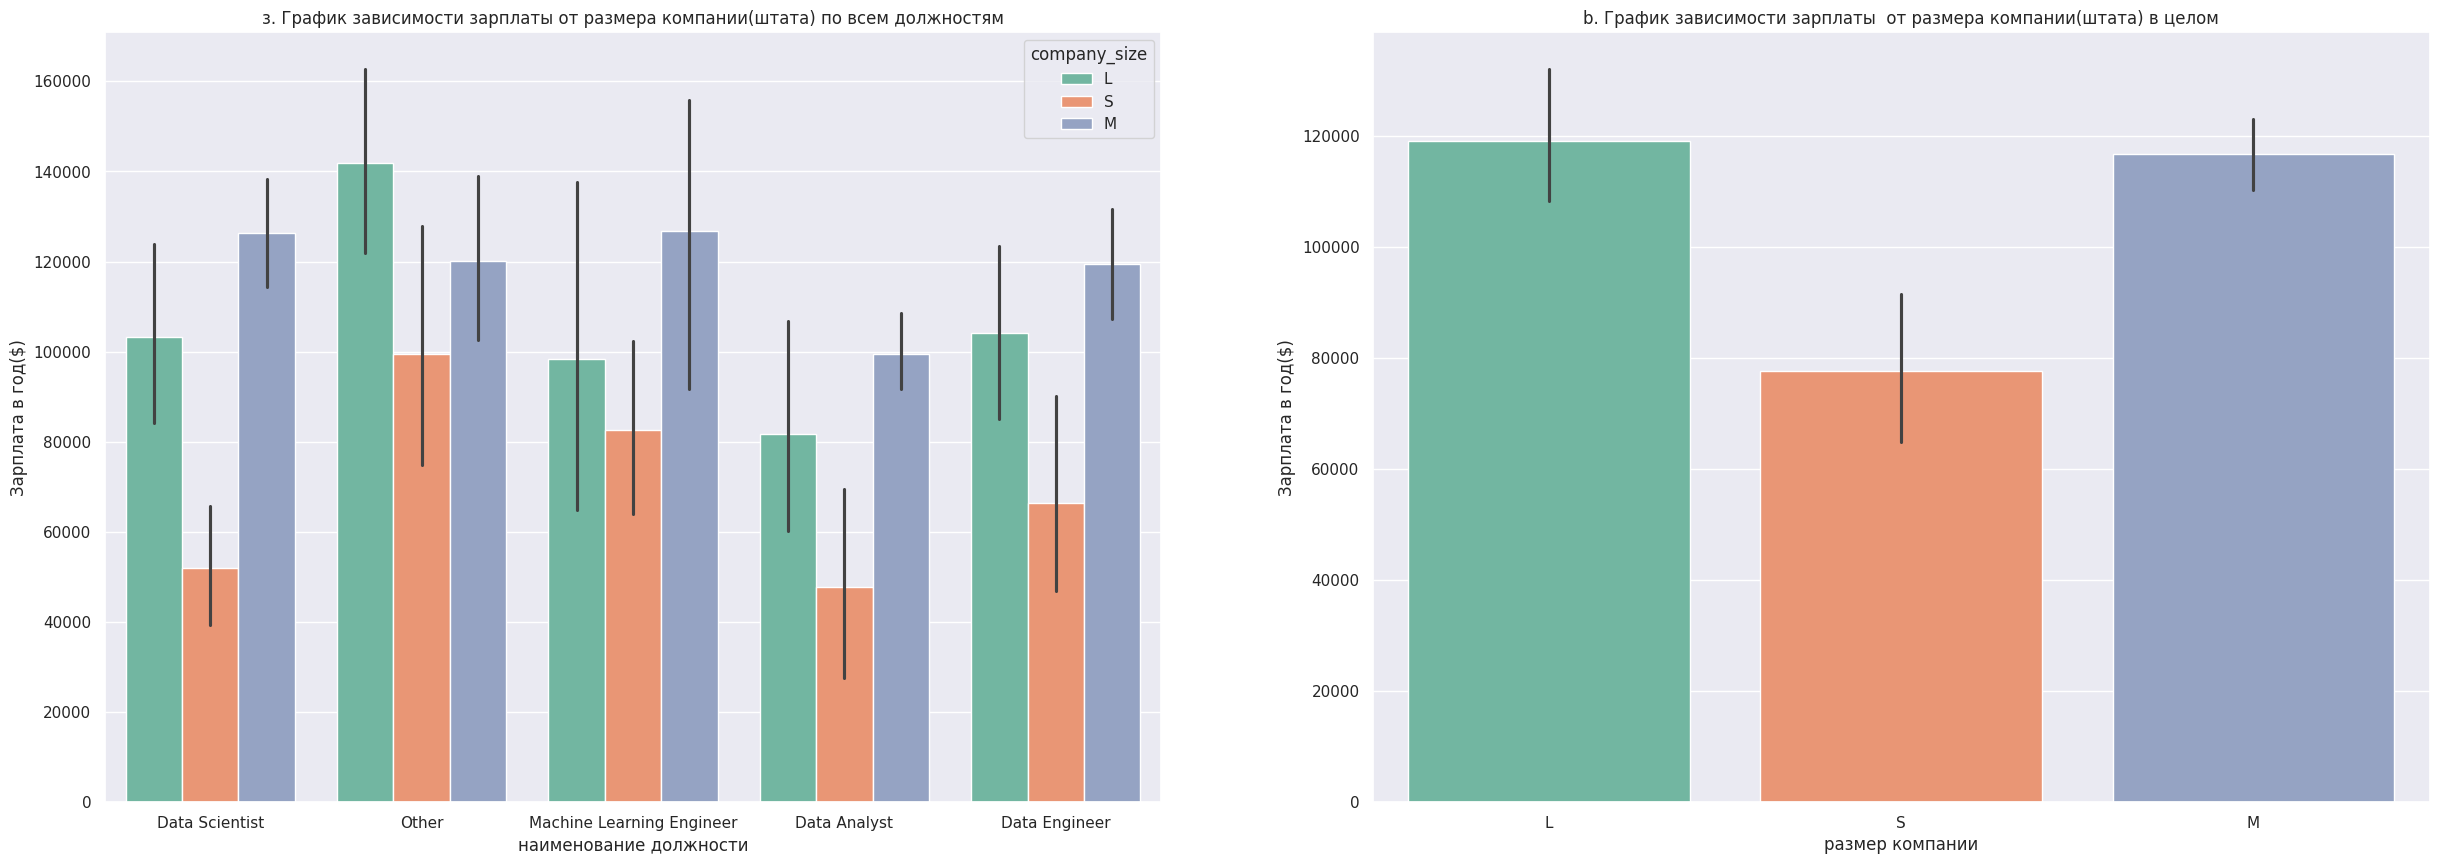

In [122]:
fig,(ax6)=plt.subplots(1,2,figsize=(30,10))
sns.barplot(df,x='job_title',y='salary_in_usd',hue='company_size',ax=ax6[0]);
ax6[0].set(xlabel='наименование должности', ylabel='Зарплата в год($)');
ax6[0].set_title('з. График зависимости зарплаты от размера компании(штата) по всем должностям');
sns.barplot(df,x='company_size',y='salary_in_usd',hue='company_size',ax=ax6[1]);
ax6[1].set(xlabel='размер компании', ylabel='Зарплата в год($)');
ax6[1].set_title('b. График зависимости зарплаты  от размера компании(штата) в целом');
display(df.groupby('company_size')['salary_in_usd'].describe().round())
display(df.groupby(['job_title','company_size'])['salary_in_usd'].describe().round())
print( ' * S — менее 50 сотрудников (небольшая компания); * M — от 50 до 250 сотрудников (средняя компания); * L — более 250 сотрудников (крупная компания).')


На графике мы видим, что в небольших компаниях зарплаты ниже всего. А дальше тенденция такова, что в компаниях со среднем штатом платят зп больше чем в компании с большим штатом сотрудников. Объясняется это тем, что в средних компаниях работы на одного сотрудника возложено больше чем в больших компаниях.   

### <center> ПЕРВЫЕ ИТОГИ(ГРАФИК) </center>

#### <center> «Какие факторы влияют на заработную плату?» </center>

1. С каждым годом зарплата специалистов Data Science растут. Зарплата 2020 года ниже чем уровень зарплат в 2022
2. Зарплата уровня SE выше чем уровня MI и EN
3. Полный рабочий день ценится выше, чем все остальные у специалистов DS
4. Самые высокие зарплаты в США, Канаде и Англии.
5. Зарплата для специалиста наиболее интересная в компании со средним штатом. Возможно это связано с там, что в средней компании приходится больше работы на себя брать, от этого и ценность выше, т.к. в больших компаниях больше специалистов и больше дробление работы. Чтобы работа двигалась быстрее и эффективнее.

### 2.2 Статистический анализ данных.  

In [19]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

### * Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

**Для этого нам необходимо сравнить все три года  по очереди.



1. **Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплаты специалиста Data Scientist в 2021 г. ($μ_1$) меньше либо равен размеру зарплаты специалиста DS ($μ_2$) в 2020 

$$ H_0 : μ_1 <= μ_2 $$

*Альтернативная гипотеза* ($H_1$): размер зарплаты специалиста Data Scientist в 2021 г. ($μ_1$) больше  размера зарплаты специалиста DS в 2020. ($μ_2$)

$$ H_1 : μ_1 > μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [20]:
# зарплаты 2020-2022
mask2020=df[df['work_year']=='2020']
salary_2020 = mask2020.loc[mask2020['job_title']=='Data Scientist', 'salary_in_usd']
mask2021=df[df['work_year']=='2021']
salary_2021 = mask2021.loc[mask2021['job_title']=='Data Scientist', 'salary_in_usd']



# проводим тест Шапиро-Уилка
print('2020г.')
result = stats.shapiro(salary_2020)
decision_normality(result[1])

print('2021г.')
result = stats.shapiro(salary_2021)
decision_normality(result[1])


2020г.
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
2021г.
p-value = 0.125
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер зарплаты в год»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

**Проведём тест**

In [21]:
_, p = stats.mannwhitneyu(salary_2021, salary_2020,alternative='greater')
decision_hypothesis(p)


p-value = 0.685
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


### Вывод:    Продолжать нет смысла, т.к. у нас нет оснований утверждать, что зарплата в 2021 году была больше чем зарплата в 2020. Следовательно У нас нет оснований утверждать, что зарплата специалиста Data Scientist растет из года в год.

### * Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплаты специалиста Data Scientist в 2022 г. ($μ_1$) меньше либо равна размеру зарплаты специалиста Data Engineer ($μ_2$) 

$$ H_0 : μ_1 <= μ_2 $$

*Альтернативная гипотеза* ($H_1$): размер зарплаты специалиста Data Scientist в 2022 г. ($μ_1$) больше  размера зарплаты специалиста Data Engineer. ($μ_2$)

$$ H_1 : μ_1 > μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данных является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [22]:
mask_DS=df[df['work_year']=='2022']
DS=mask_DS.loc[mask_DS['job_title']=='Data Scientist','salary_in_usd']
mask_DE=df[df['work_year']=='2022']
DE=mask_DE.loc[mask_DE['job_title']=='Data Engineer','salary_in_usd']
# проводим тест Шапиро-Уилка
print('Data Scientist')
result = stats.shapiro(DS)
decision_normality(result[1])

print('Data Engineer')
result = stats.shapiro(DE)
decision_normality(result[1])


Data Scientist
p-value = 0.327
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Data Engineer
p-value = 0.010
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер зарплаты в год»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

**Проведём тест**

In [23]:
_, p = stats.mannwhitneyu(DS, DE,alternative='greater')
decision_hypothesis(p)

p-value = 0.077
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


### Вывод: У нас нет оснований утверждать, что зарплата специалистов Data Scientist в 2022 году была больше чем  зарплата Data Engineer в этом же году.

### * Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплаты специалиста Data Scientist в компаниях различных размеров равны. 
* ($μ_1$) -размер компании  S — менее 50 сотрудников (небольшая компания); 
* ($μ_2$)- M от 50 до 250 сотрудников (средняя компания);
* ($μ_3$)- L — более 250 сотрудников (крупная компания).

$$ H_0 : μ_1 = μ_2 = μ_3 $$

*Альтернативная гипотеза* ($H_1$) размер зарплаты специалиста Data Scientist в компаниях различных размеров не равны.

$$ H_1 : μ_1 \neq  μ_2 \neq  μ_3$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. 

*Нулевая гипотеза* ($H_0$): распределение данных является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [24]:
# зарплаты специалиста DS в компаниях различных размеров
maskS=df[df['company_size']=='S']
salary_S = maskS.loc[maskS['job_title']=='Data Scientist', 'salary_in_usd']
maskM=df[df['company_size']=='M']
salary_M = maskM.loc[maskM['job_title']=='Data Scientist', 'salary_in_usd']
maskL=df[df['company_size']=='L']
salary_L = maskL.loc[maskL['job_title']=='Data Scientist', 'salary_in_usd']


# проводим тест Шапиро-Уилка
print('Company S')
result = stats.shapiro(salary_S)
decision_normality(result[1])

print('Company M')
result = stats.shapiro(salary_M)
decision_normality(result[1])

print('Company L')
result = stats.shapiro(salary_L)
decision_normality(result[1])

Company S
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Company M
p-value = 0.639
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Company L
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер зарплаты в год»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать КРИТЕРИЙ КРАСКЕЛА — УОЛЛИСА ИСПОЛЬЗУЕТСЯ ДЛЯ 3+ НЕЗАВИСИМЫХ ГРУПП С НЕНОРМАЛЬНЫМ РАСПРЕДЕЛЕНИЕМ.

**Проведём тест**

In [25]:
_, p = stats.kruskal(salary_S,salary_M,salary_L)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


### Вывод:    Размер зарплаты специалиста Data Scientist в компаниях различных размеров не равны. Это подтверждает наш график, созданный ранее.

Теперь проверим нашу след. гепотезу, относительно графика.


### * Зарплата в компаниях со средним размером штата предлагают цифру выше чем в крупных компаниях для специалистов Data Scientist?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплаты специалиста Data Scientist в  M средней компании (μ_1) меньше или равна зарплатам L крупной компании ($μ_2$) 

$$ H_0 : μ_1 <= μ_2 



*Альтернативная гипотеза* ($H_1$): размер зарплаты специалиста Data Scientist в  M средней компании (μ_1) больше зарплат чем в L крупной компании ($μ_2$) 

$$ H_1 : μ_1 > μ_2$$

Распределение данных является отличным от нормального.

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер зарплаты в год»? — Количественный.
* Сколько сравниваемых групп? — Два.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

**Проведём тест**

In [26]:
_, p = stats.mannwhitneyu(salary_M , salary_L,alternative='greater')
decision_hypothesis(p)

p-value = 0.006
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


### Вывод:    Размер зарплаты специалиста Data Scientist в компаниях M больше чем предлагают зарплаты компании L.

### * Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: Между  наличием должностей Data Scientist и Data Engineer и размером компании нет взаимосвязи (признаки независимы)

*Альтернативная гипотеза*: между наличием должностей Data Scientist и Data Engineer и размером компании есть взаимосвязь (признаки зависимы).

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «job_title»? — Категориальный.
* Сколько сравниваемых групп? — Две.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [27]:
# составляем таблицу сопряжённости
mask=df[(df['job_title']=='Data Scientist') | (df['job_title']=='Data Engineer')]
cross_table = pd.crosstab(mask['job_title'], mask['company_size'])

cross_table

company_size,L,M,S
job_title,,,
Data Engineer,37,89,6
Data Scientist,45,77,21


In [28]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)

p-value = 0.008
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Существует статистически значимая взаимосвязь между должностью и размером компании.

### * Равны ли зарплаты при разных типах трудоустройства?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплаты  с типом PT (μ_1) равна типу FT($μ_2$) равна типу CT ($μ_3$) равна типу FL ($μ_4$). 

Тип трудоустройства для этой роли:
    * PT — неполный рабочий день;
    * FT — полный рабочий день;
    * CT — контракт;
    * FL — фриланс. 

$$ H_0 : μ_1 = μ_2 = μ_3 = μ_4 $$

*Альтернативная гипотеза* ($H_1$) Размер зарплаты  с разным типом трудоустройств не равны.

$$ H_1 : μ_1 \neq  μ_2 \neq  μ_3\neq  μ_4$$


**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. 

*Нулевая гипотеза* ($H_0$): распределение данных является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [29]:
# зарплаты  в зависимости от типа трудоустройства.
salary_PT = df.loc[df['employment_type']=='PT','salary_in_usd']

salary_FT = df.loc[df['employment_type']=='FT','salary_in_usd']

salary_CT = df.loc[df['employment_type']=='CT','salary_in_usd']

salary_FL = df.loc[df['employment_type']=='FL','salary_in_usd']


# проводим тест Шапиро-Уилка
print('тип трудоустройства PT-Неполный рабочий день.')
result = stats.shapiro(salary_PT)
decision_normality(result[1])

print('тип трудоустройства FT-Полный рабочий день.')
result = stats.shapiro(salary_FT)
decision_normality(result[1])

print('тип трудоустройства CT-контракт')
result = stats.shapiro(salary_CT)
decision_normality(result[1])

print('тип трудоустройства FL-Фриланс')
result = stats.shapiro(salary_FL)
decision_normality(result[1])

тип трудоустройства PT-Неполный рабочий день.
p-value = 0.023
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
тип трудоустройства FT-Полный рабочий день.
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
тип трудоустройства CT-контракт
p-value = 0.406
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
тип трудоустройства FL-Фриланс
p-value = 0.507
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер зарплаты в год»? — Количественный.
* Сколько сравниваемых групп? — Четыре.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать КРИТЕРИЙ КРАСКЕЛА — УОЛЛИСА ИСПОЛЬЗУЕТСЯ ДЛЯ 3+ НЕЗАВИСИМЫХ ГРУПП С НЕНОРМАЛЬНЫМ РАСПРЕДЕЛЕНИЕМ.

**Проведём тест**

In [30]:
_, p = stats.kruskal(salary_PT,salary_FT,salary_CT,salary_FL)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


### Вывод:    Размер зарплаты при разных типах трудоустройств не равен.

### * Размер зарплаты в США самый высокий? 

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплаты  В США (μ_1) ниже либо равен уровню зарплаты в остальных странах($μ_2$)  



$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$) Размер зарплаты  в США выше чем в других странах

$$ H_1 : μ_1 > μ_2 

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. 

*Нулевая гипотеза* ($H_0$): распределение данных является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [31]:
# зарплаты  в зависимости от страны
salary_US=df.loc[df['company_location']=='US','salary_in_usd']
salary_Other=df.loc[df['company_location'] != 'US','salary_in_usd']

# проводим тест Шапиро-Уилка
print('зарплата США')
result = stats.shapiro(salary_US)
decision_normality(result[1])

print('зарплата в других странах')
result = stats.shapiro(salary_Other)
decision_normality(result[1])

зарплата США
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
зарплата в других странах
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер зарплаты в год»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

**Проведём тест**

In [32]:
_, p = stats.mannwhitneyu(salary_US, salary_Other,alternative='greater')
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


### Вывод:    Размер зарплаты с США выше чем в других странах.

### * Зарплата специалиста Data Scientist в среднем больше чем 100 тыс. долларов в 2022 году?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплаты  для специалистов Data Scientist (μ_1) ниже либо равен 100 тыс. долларов  



$$ H_0 : μ_1 <= 100 000$$

*Альтернативная гипотеза* ($H_1$) Размер зарплаты  для специалистов Data Scientist (μ_1) больше 100 тыс. долларов

$$ H_1 : μ_1 > 100 000 

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. 

*Нулевая гипотеза* ($H_0$): распределение данных является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [33]:
mask=df[df['work_year']=='2022']
salary_DSc = mask.loc[mask['job_title']=='Data Scientist','salary_in_usd']


# проводим тест Шапиро-Уилка
print('зарплата специалиста Data Scientist')
result = stats.shapiro(salary_DSc)
decision_normality(result[1])

зарплата специалиста Data Scientist
p-value = 0.327
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер зарплаты в год»? — Количественный.
* Сколько сравниваемых групп? — одна.
* Признак распределён по нормальному закону? — Да.

Для проверки нашей гипотезы можно использовать Одновыборочный Т-критерий.

**Проведём тест**

In [34]:
_, p = stats.ttest_1samp(salary_DSc, popmean=100000, alternative='greater')
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


### Вывод:    Размер зарплаты в 2022 году у специалиста Data Scientist больше 100 тыс. долларов. Что не может не радовать :)

## Итак мой общий вывод следующий:

1. Нет никаких оснований утверждать, что зарплата специалиста Data Scientist растет с каждым годом.

2. Так же нет оснований утверждать, что зарплата специалистов Data Scientist в 2022 году была больше чем у Data Engineer в том же году.

3. Зарплата специалистов DS зависит от размера компании . Так же уровень зарплат в средних компаниях выше чем уровень зарплат в крупных компаниях.

4. Существует статистически значимая взаимосвязь между должностью Data Scientist и Data Engineer и размером компании.

5. Размер зарплаты при разных типах трудоустройств не равен.

6. Размер зарплаты с США выше чем в других странах.

7. Размер зарплаты в 2022 году у специалиста Data Scientist больше 100 тыс. долларов в год.